In [54]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

In [9]:
from rl.expert.utils import process_transitions

transitions_path = Path.cwd() / 'expert' / 'trial_2'
transitions = process_transitions(transitions_path)

Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_11
dict_keys(['guidewire/joint_positions', 'guidewire/joint_velocities', 'guidewire/tip/joint_positions', 'guidewire/tip/joint_velocities'])
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_26
dict_keys(['guidewire/joint_positions', 'guidewire/joint_velocities', 'guidewire/tip/joint_positions', 'guidewire/tip/joint_velocities'])
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_00
dict_keys(['guidewire/joint_positions', 'guidewire/joint_velocities', 'guidewire/tip/joint_positions', 'guidewire/tip/joint_velocities'])
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/episode_02
dict_keys(['guidewire/joint_positions', 'guidewire/joint_velocities', 'guidewire/tip/joint_positions', 'guidewire/tip/joint_velocities'])
Processing:  /home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/expert/trial_2/epis

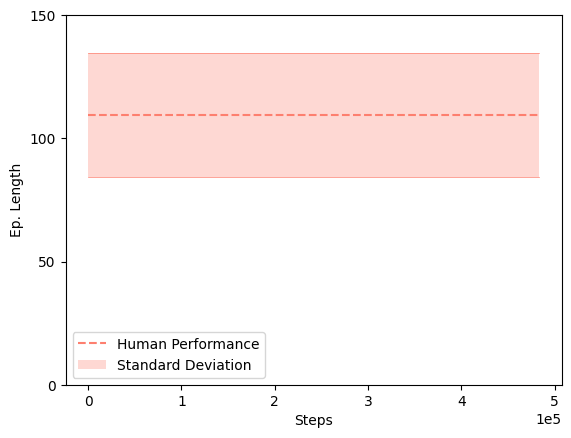

In [18]:
# Generate some data
time_steps = 500_000
n_ticks = 30
x = np.arange(0, time_steps, time_steps/n_ticks)
# make the same value appear in all 30 ticks
y = np.full(n_ticks, 109.45)
y_std = 25.16

# Plot the line, make it dashed
plt.plot(x, y, label='Human Performance', linestyle='--')

# Fill the area between the line and +- y_std
plt.fill_between(x, y - y_std, y + y_std, alpha=0.3, label='Standard Deviation')
# make two lines that contain the mean +- std
# make it the same color as the line above
plt.plot(x, y - y_std, color='C0', linewidth=0.5)
plt.plot(x, y + y_std, color='C0', linewidth=0.5)

# Add legend and labels
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Ep. Length')
# make y ticks from 50 to 300
plt.yticks(np.arange(0, 200, 50))
# use k not thousands for x ticks
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
# Show the plot
plt.show()

## Tensorboard Data

Tag not found
(30,) (30,)


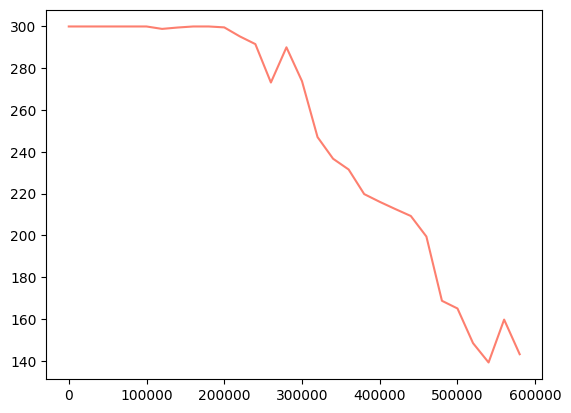

In [36]:
from rl.sb3.evaluation import  get_experiment_tensorboard_logs, collate_experiments_tensorboard_logs, plot_error_line_graph, get_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tb_log_path = '/home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/sb3/experiments/full/logs/sac_0_0/events.out.tfevents.1678944977.pop-os.282274.0'


mean, stdev = collate_experiment_tensorboard_logs('internal')
plt.plot(mean.index, mean, label='RL Performance')

In [74]:
from rl.sb3.evaluation import  get_experiment_tensorboard_logs, collate_experiments_tensorboard_logs, plot_error_line_graph, get_data, parse_tensorboard_log, make_experiment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def parse_tensorboard_log(path: Path):
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
    import pandas as pd

    tag = 'rollout/ep_len_mean'
    acc = EventAccumulator(path)
    acc.Reload()
    # check if the tag exists

    if tag not in acc.Tags()['scalars']:
        print("Tag not found")
        return
    df = pd.DataFrame(acc.Scalars(tag))
    df = df.drop(columns=['wall_time']).groupby('step').mean()
    return df

def get_experiment_tensorboard_logs(experiment_name: str):
    _, experiment_log_path, _ = make_experiment(experiment_name)
    logs = []
    for model in experiment_log_path.iterdir():
        if not model.is_dir():
            continue
        for log in model.iterdir():
            tensorboard_log = parse_tensorboard_log(log.as_posix())
            if tensorboard_log is not None:
                logs.append(tensorboard_log)
    return logs

def collate_experiment_tensorboard_logs(experiment_name: str, n_interpolations: int = 30):
    logs = get_experiment_tensorboard_logs(experiment_name)
    logs = [log.reindex(np.arange(0, 600_000, 600_000 / n_interpolations), method='nearest') for log in logs]
    mean = pd.concat(logs, axis=0).groupby(level=0).mean().squeeze()
    stdev = pd.concat(logs, axis=0).groupby(level=0).std().squeeze()
    return mean, stdev

def collate_experiments_tensorboard_logs(experiments_path: Path = None, n_interpolations: int = 30):
    if not experiments_path:
        experiments_path = Path.cwd() / 'sb3' / 'experiments' 
    results = {}
    for experiment in experiments_path.iterdir():
        if not experiment.is_dir():
            continue
        print(experiment.name)
        mean, stdev = collate_experiment_tensorboard_logs(experiment.name, n_interpolations)
        results[experiment.name] = dict(mean=mean, stdev=stdev)
    return results

# experiment_tb_logs = collate_experiment_tensorboard_logs('internal')
# print(experiment_tb_logs)

results = collate_experiments_tensorboard_logs(path, n_interpolations=30)
# experiment_tb = get_experiment_tensorboard_logs('internal')
# print(experiment_tb)
# print(results)

pixels_mask
full
internal_pixels
internal
Tag not found
pixels


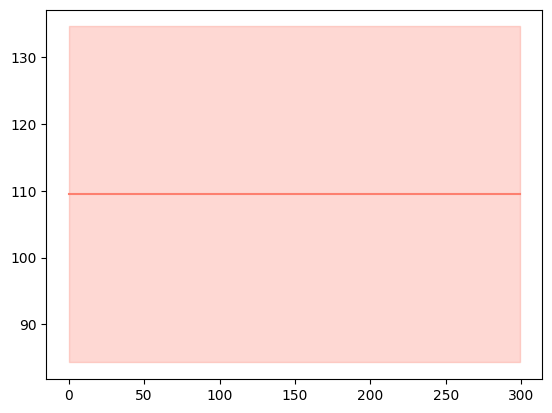

In [79]:
def plot_error_line_graph(mean, stdev, label, color='C0', **kwargs):
    if not isinstance(mean, pd.Series):
        mean = pd.Series(mean)
    x = mean.index
    plt.plot(x, mean, color=color, label=label, **kwargs)
    plt.fill_between(x, mean - stdev, mean + stdev, alpha=0.3, color=color)

# plot_error_line_graph(mean, stdev, label='RL Performance')

n_interpolations = 300
human_mean = np.linspace(109.45, 109.45, n_interpolations)
human_stdev = np.linspace(25.16, 25.16, n_interpolations)
plot_error_line_graph(human_mean, human_stdev, label='Human Performance')

Tag not found


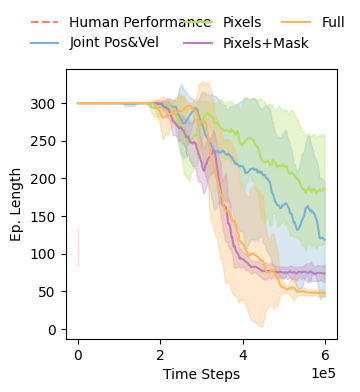

In [87]:
from rl.sb3.evaluation import  get_experiment_tensorboard_logs, collate_experiments_tensorboard_logs, plot_error_line_graph, get_data, parse_tensorboard_log, make_experiment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_error_line_graph(mean, stdev, label, color='C0', **kwargs):
    if not isinstance(mean, pd.Series):
        mean = pd.Series(mean)
    x = mean.index
    plt.plot(x, mean, color=color, label=label, **kwargs)
    plt.fill_between(x, mean - stdev, mean + stdev, alpha=0.3, color=color)

colors = sns.color_palette('deep')
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colors)

n_interpolations = 300
human_mean = np.linspace(109.45, 109.45, n_interpolations)
human_stdev = np.linspace(25.16, 25.16, n_interpolations)
plot_error_line_graph(human_mean, human_stdev, label='Human Performance', color='C0', linestyle='--')
results = collate_experiments_tensorboard_logs(n_interpolations=n_interpolations)
results = {k: results[k] for k in ['internal', 'pixels', 'pixels_mask', 'full']}
results_titles = ['Joint Pos&Vel', 'Pixels', 'Pixels+Mask', 'Full']
for i, (experiment, values) in enumerate(results.items()):
    mean, stdev = values['mean'], values['stdev']
    plot_error_line_graph(mean, stdev, label=results_titles[i], color=f'C{i+1}')

# format the ticks on x axis to be in k
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.xlabel('Time Steps')
plt.ylabel('Ep. Length')
plt.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.02, 1.2, 0.2), ncol=3, mode='expand', borderaxespad=0, frameon=False)
plt.gcf().set_size_inches(3.5, 3.5)
# plt.tight_layout()
plt.show()
# plt.legend()

In [5]:
def plot_error_line_graph(n, mean, stdev, label, color='C0',**kwargs):
    x = np.arange(0, 600_000, 600_000/n)
    plt.plot(x, mean, color=color, label=label,**kwargs)
    plt.fill_between(x, mean - stdev, mean + stdev, alpha=0.3, color=color)

# plot_error_line_graph(mean, stdev, 'Internal', color='C1')

In [39]:
# traverse a directory and get all the files
from pathlib import Path

# write a function that does all of the above
def get_data_from_dir(path):
    df = pd.DataFrame(columns=['value'])
    for folder in path.iterdir():
        for i, file in enumerate(folder.iterdir()):
            file_df = get_data(file.as_posix())
            # Interpolate the data points to align them properly
            file_df = file_df.reindex(np.arange(0, 500_000, 500_000/208), method='nearest')
            # rename the column to an integer
            file_df = file_df.rename(columns={'value': i})
            # concatenate the dataframes
            df = pd.concat([df, file_df],axis=1)
    # round the index to integers
    df.index = np.round(df.index.astype(int))
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    # drop all besides the mean and std
    df = df.iloc[:, -2:]

    return df
path = Path.cwd() / 'sb3' / 'experiments' / 'internal' / 'logs'
print(path)
cleaned_data = get_data_from_dir(path)
print(len(cleaned_data))

cleaned_data

/home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/sb3/experiments/internal/logs


TypeError: get_data() takes 0 positional arguments but 1 was given

In [9]:
def plot_error_line_graph(df,label, color='C0'):
    x = np.arange(0, 500_000, 500_000/208)
    means = df['mean'].to_numpy()
    stds = df['std'].to_numpy()
    plt.plot(x, means, color=color, label=label)
    plt.fill_between(x, means - stds, means + stds, alpha=0.3, color=color)

plot_error_line_graph(cleaned_data, 'RL Performance', color='C1')

NameError: name 'cleaned_data' is not defined

In [89]:
# traverse a directory and get all the files
from pathlib import Path

# write a function that does all of the above
def get_data_from_dir(path):
    df = pd.DataFrame()
    for folder in path.iterdir():
        for file in folder.iterdir():
            file_df = get_data(file.as_posix())
            df = pd.concat([df, file_df], axis=1)
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df = df.drop(columns=df.columns[:-2])
    return df
path = Path.cwd() / 'sb3' / 'experiments' / 'internal' / 'logs'
cleaned_data = get_data_from_dir(path)
print(len(cleaned_data))

# rewrite the index to finish with the 500_000 step
cleaned_data['steps'] = np.arange(0, 500_000, 500_000/416)
cleaned_data

TypeError: get_data() takes 0 positional arguments but 1 was given

In [11]:
#plot cleaned data
plt.plot(cleaned_data['steps'], cleaned_data['mean'], label='Human Performance', linestyle='--')

NameError: name 'cleaned_data' is not defined

In [34]:
segment_path = Path.cwd() / 'sb3' / 'experiments' / 'multi_input_w_segment_3' / 'logs'
segment_data = get_data_from_dir(segment_path)
# delete the first 10 rows
# segment_data = segment_data.iloc[15:]
segment_data['steps'] = np.arange(0, 500_000, 500_000/301)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tudorjnu/Projects/cathsim/cathsim-mjcf-dev/rl/sb3/experiments/multi_input_w_segment_3/logs'

NameError: name 'cleaned_data' is not defined

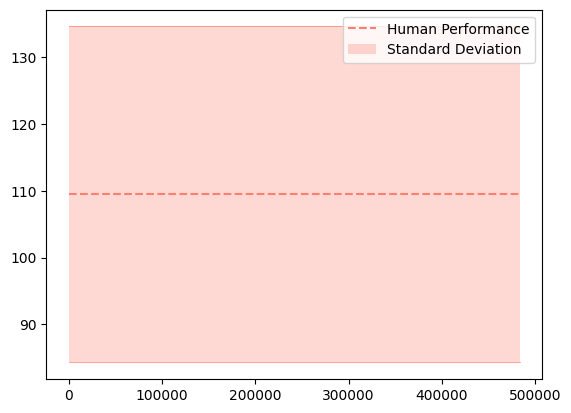

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# make the plot from above into a function
def plot_data(data:pd.DataFrame, label:str='Human Performance'):
    means = data['mean']
    stds = data['std']
    time_steps = 500_000
    print(time_steps)
    n_ticks = 285
    x = np.arange(0, time_steps, time_steps/n_ticks)
    # make the same value appear in all 30 ticks
    y = data['mean']
    y_std = data['std']

    # Plot the line, make it dashed
    plt.plot(x, y, label=label, linestyle='--')

    # Fill the area between the line and +- y_std
    plt.fill_between(x, y - y_std, y + y_std, alpha=0.3, label='Standard Deviation')
    # make two lines that contain the mean +- std
    # make it the same color as the line above
    plt.plot(x, y - y_std, color='C1', linewidth=0.5)
    plt.plot(x, y + y_std, color='C1', linewidth=0.5)

    # Add legend and labels
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Ep. Length')
    # make y ticks from 50 to 300
    plt.yticks(np.arange(0, 350, 50))
    # use k not thousands for x ticks
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# Generate some data
time_steps = 500_000
n_ticks = 30
x = np.arange(0, time_steps, time_steps/n_ticks)
# make the same value appear in all 30 ticks
y = np.full(n_ticks, 109.45)
y_std = 25.16

# Plot the line, make it dashed
plt.plot(x, y, label='Human Performance', linestyle='--')

# Fill the area between the line and +- y_std
plt.fill_between(x, y - y_std, y + y_std, alpha=0.3, label='Standard Deviation')
# make two lines that contain the mean +- std
# make it the same color as the line above
plt.plot(x, y - y_std, color='C0', linewidth=0.5)
plt.plot(x, y + y_std, color='C0', linewidth=0.5)

# Add legend and labels
plt.legend()

def plot_human_performance(transitions):
    # get the data from the transitions
    data = transitions['ep_infos']
    # make a dataframe from the data
    df = pd.DataFrame(data)
    # get the mean and std
    mean = df['ep_length'].mean()
    std = df['ep_length'].std()
    # make the plot
    plot_data(mean, std)

plot_data(cleaned_data, label='Joints')
plot_data(segment_data, label='Segments')

TypeError: get_data() takes 0 positional arguments but 1 was given

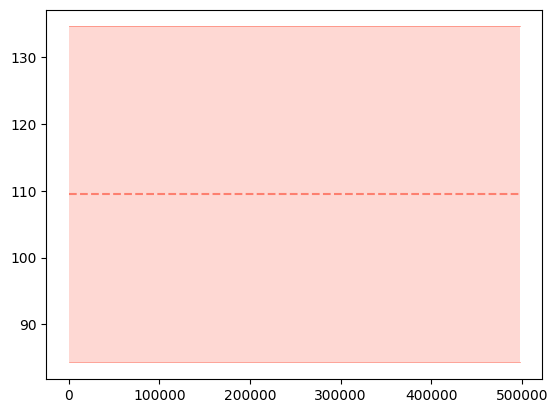

In [90]:
# Generate some data
time_steps = 500_000
n_ticks = 208
x = np.arange(0, time_steps, time_steps/208)
# make the same value appear in all 30 ticks
y = np.full(n_ticks, 109.45)
y_std = 25.16

# Plot the line, make it dashed
plt.plot(x, y, label='Human Performance', linestyle='--')

# Fill the area between the line and +- y_std
plt.fill_between(x, y - y_std, y + y_std, alpha=0.3)
# make two lines that contain the mean +- std
# make it the same color as the line above
plt.plot(x, y - y_std, color='C0', linewidth=0.5)
plt.plot(x, y + y_std, color='C0', linewidth=0.5)

image_only = Path.cwd() / 'sb3' / 'experiments' / 'pixels' / 'logs'
image_only_data = get_data_from_dir(image_only)
plot_error_line_graph(image_only_data, label='Image Only', color='C1')

path = Path.cwd() / 'sb3' / 'experiments' / 'internal' / 'logs'
cleaned_data = get_data_from_dir(path)
plot_error_line_graph(cleaned_data, label='Joints', color='C2')

segment_path = Path.cwd() / 'sb3' / 'experiments' / 'full' / 'logs'
segment_data = get_data_from_dir(segment_path)
plot_error_line_graph(segment_data, label='Full Model', color='C3')



plt.legend(loc='lower left')
plt.xlabel('Steps')
plt.ylabel('Ep. Length')


## Force Analysis

In [4]:
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint

evaluation_path = Path.cwd()  / 'sb3' / 'evaluation'

def get_experiment_data(experiment_file:Path) -> np.ndarray:
    """ Takes an experiment file with results and returns the data as a numpy array """
    assert experiment_file.suffix == '.npz', 'File must be a .npy file'
    data = dict(np.load(experiment_file, allow_pickle=True))
    return data['results']

def get_data_from_dir(path:Path) -> dict:
    """ Iterates through a directory and returns a dictionary of all experiments found"""
    from collections import OrderedDict
    data = OrderedDict()
    for file in path.iterdir():
        if file.suffix == '.npz':
            data[file.stem] = get_experiment_data(file)
    print(f'Found {len(data)} experiments')
    print(f'\tExperiments:', end=' ')
    pprint(list(data.keys()))
    return data

data = get_data_from_dir(evaluation_path)

Found 6 experiments
	Experiments: ['full', 'pixels', 'internal_pixels', 'pixels_mask', 'internal', 'bc']


## Force Analysis

dict_keys(['forces', 'head_positions'])


/tmp/ipykernel_945/472056149.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([names_mapping[name] for name in labels],


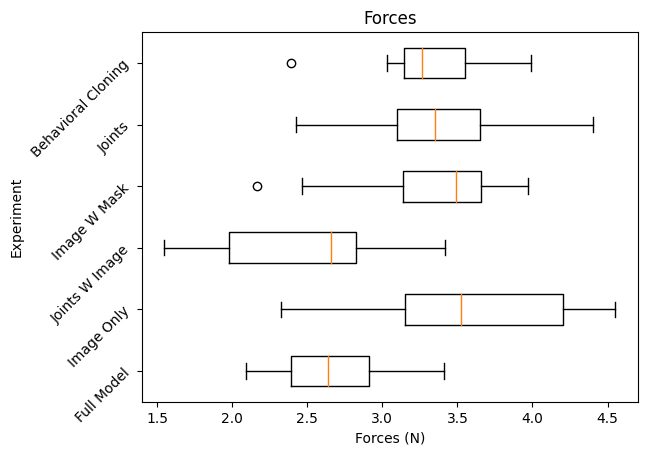

In [60]:
full_experiment = data['full']
experiment_attributes = full_experiment[0].keys()
pprint(experiment_attributes)

names_mapping = {'full': 'Full Model', 'internal': 'Joints', 'pixels': 'Image Only', 
                 'bc': 'Behavioral Cloning', 'pixels_mask': 'Image W Mask', 'internal_pixels': 'Joints W Image', 
                 'internal_pixels_mask': 'Joints W Image W Mask', 'internal_mask': 'Joints W Mask'}

def plot_boxplot(data:dict, attribute:str, fn: callable)-> None:
    """ Plots a boxplot for each experiment in the data dictionary """
    fig, ax = plt.subplots()
    ax.set_title(attribute.capitalize())
    ax.set_xlabel(attribute.capitalize() + ' (N)')
    ax.set_ylabel('Experiment')
    labels, values = zip(*data.items())
    ax.set_yticklabels([names_mapping[name] for name in labels],
                       rotation=45)
    # make the boxplot in landscape
    ax.boxplot([fn(experiment) for experiment in values], vert=False)
    # make the boxplot horizontal
    plt.show()

plot_boxplot(data, 'forces', lambda x: [np.mean(episode['forces']) for episode in x])


## Path Analysis

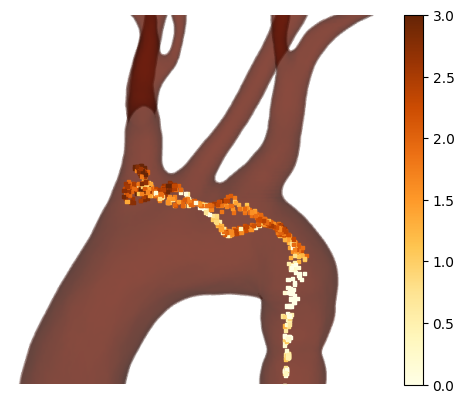

In [72]:
def point2pixel(point, camera_matrix: np.ndarray = None):
    """Transforms from world coordinates to pixel coordinates."""
    if camera_matrix is None:
        camera_matrix = np.array([
            [-5.79411255e+02, 0.00000000e+00, 2.39500000e+02, - 5.33073376e+01],
            [0.00000000e+00, 5.79411255e+02, 2.39500000e+02, - 1.08351407e+02],
            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, - 1.50000000e-01]
        ])
    x, y, z = point
    xs, ys, s = camera_matrix.dot(np.array([x, y, z, 1.0]))

    return round(xs / s), round(ys / s)


def plot_guidewire_path(data:dict, experiment:str='full'):
    """ Plots the guidewire path for each episode in an experiment """
    # load phantom image
    phantom = plt.imread('../figures/phantom_2.png') 
    # rotate the image 180 degrees
    phantom = np.rot90(phantom, 2)
    # flip the image horizontally
    phantom = np.fliplr(phantom)
    
    
    plt.axis('off')
    # set the x and y limits
    plt.xlim(0, 480)
    plt.ylim(0, 480)
    for i, episode in enumerate(data[experiment]):
        head_pos = episode['head_positions']
        forces = episode['forces']
        # scale the forces between 1 and 3
        # forces = np.interp(forces, (forces.min(), forces.max()), (1, 3))
        # rescale the forces with a standard deviation of 0.3, a minimum value of 0 and a maximum value of 3
        forces = np.interp(forces, (forces.min(), forces.max()), (0, 3))
        # convert the head positions to pixels
        head_pos = np.array([point2pixel(point) for point in head_pos])
        # flip the y axis
        head_pos[:, 1] = 480 - head_pos[:, 1]
        plt.scatter(head_pos[1:, 0], head_pos[1:, 1], c=forces, cmap='YlOrBr', vmin=0, vmax=3, marker='s', s=5)
        if i == 19:
            break  
    # create a colorbar for the forces
    # make the colorbar from 1 to 3
    cbar = plt.colorbar(ticks=[0, 0.5,1,1.5, 2,2.5, 3])
    plt.imshow(phantom)
    plt.show()


plot_guidewire_path(data)

## Stats Force Analysis

In [68]:
import scipy.stats as stats
# plt.rcParams["figure.figsize"] = (plt.rcParams["figure.figsize"][0]/2 ,plt.rcParams["figure.figsize"][1]/2)
# sns.set_palette("deep")

# Read the data from the csv file
df = pd.read_csv('../../data/kundrat2021mrsafe.csv',parse_dates=['Time'], usecols=['Time','F_res [N]'])
df['Time'] = df['Time'].str[:-3]
df['Time']= pd.to_datetime(df['Time']).dt.time
# df_real = df.groupby(df['Time']).mean()
df_real = df['F_res [N]'].to_numpy()
df_real = stats.norm(0.4,0.2)
# df_real = df_real.cdf(np.linspace(-2,2,1000))

df_sim = data['full']
df_sim = pd.DataFrame([episode['forces'] for episode in full_data]).stack().reset_index(drop=True)
# df_sim = pd.read_csv('./cathsim-mjcf/cathsim-mjcf/force.csv')
# df_sim = df_sim.groupby(df_sim['step']).mean()
# df_sim = np.linalg.norm(df_sim[['normal z', 'friction x', 'friction y']],axis=1)
q1,q3 =np.percentile(df_sim, [25, 75])
df_sim = df_sim[(df_sim<q3) & (df_sim>q1)]


df_real = df_real.rvs(size=len(df_sim), random_state=42)

In [66]:
full_data = data['full']
# create a single dataframe with all the forces from all the experiments
df_sim = pd.DataFrame([episode['forces'] for episode in full_data]).stack().reset_index(drop=True)
df_sim.head()

0    6.495556e-09
1    3.202821e-08
2    7.495421e-08
3    1.323164e-07
4    1.997880e-07
dtype: float64

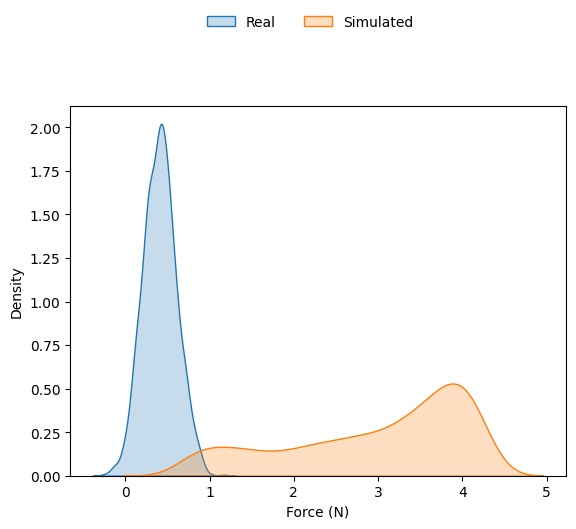

In [69]:
fig, ax = plt.subplots()

sns.kdeplot(df_real, label="Real", fill=True)
sns.kdeplot(df_sim, label="Simulated", fill=True)
plt.xlabel("Force (N)")
plt.legend()
plt.savefig("force.png")
handles, labels = ax.get_legend_handles_labels()    
    
# axs[1].set(ylabel=None, xlabel="Type-II Aortic Arch")
   
ax.get_legend().remove()
# axs[1].get_legend().remove()
for i, label in enumerate(labels):
    labels[i] = label


legend = fig.legend(handles, labels, loc='upper center', ncol=2, borderaxespad=0., bbox_to_anchor=(0., 0.98, 1., .102), frameon=False)

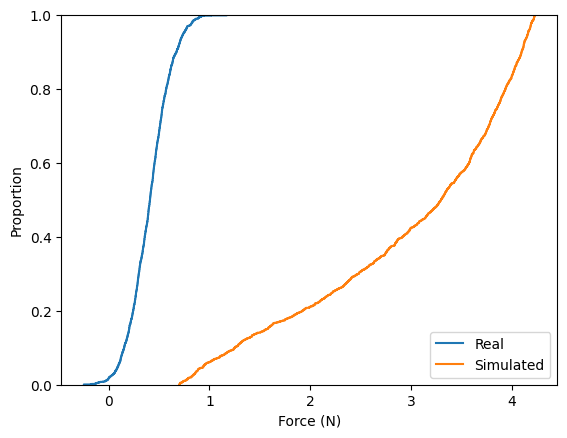

In [70]:
sns.ecdfplot(df_real, label="Real")
sns.ecdfplot(df_sim, label="Simulated")
plt.legend()
plt.xlabel("Force (N)")
plt.savefig("force_ecdf.png")

In [ ]:
plt.boxplot([df_real, df_sim], labels=["Real", "Simulated"], showfliers=False, meanline=True, patch_artist=True)
plt.ylabel("Force (N)")
plt.savefig("boxplot.png")

In [ ]:
# make a figure with one subplot
fig, ax = plt.subplots(1, 1, figsize=(plt.rcParams["figure.figsize"][0]/2 ,plt.rcParams["figure.figsize"][1]/2))
stats.probplot(df_sim, dist="norm", plot=ax)
# change the colour of the markers in ax
# ax.get_lines()[0].set_markeredgecolor((191/255, 97/255, 106/255, 1))
# change the colour of spine in ax
# ax.get_lines()[1].set_color((00.639, 0.745, 0.549, 1))

plt.show()
plt.savefig("qq.png")

In [ ]:
fig, axs = plt.subplots(1,2, squeeze=True, figsize=(plt.rcParams["figure.figsize"][0] ,plt.rcParams["figure.figsize"][1]*0.67))
# axs[0].set_aspect("equal")
# axs[1].set_aspect("auto")

sns.ecdfplot(df_real, label="Real", ax=axs[1])
sns.ecdfplot(df_sim, label="Simulated",ax=axs[1])
axs[1].legend()
axs[1].set_xlabel("Force (N)")
# axs[1].savefig("force_ecdf.png")

sns.kdeplot(df_real, label="Real", fill=True, ax=axs[0])
sns.kdeplot(df_sim, label="Simulated", fill=True, ax=axs[0])
axs[0].set_xlabel("Force (N)")
axs[0].legend()
# axs[0].savefig("force.png")
handles, labels = axs[1].get_legend_handles_labels()    
    
# axs[1].set(ylabel=None, xlabel="Type-II Aortic Arch")
   
axs[0].get_legend().remove()
axs[1].get_legend().remove()
for i, label in enumerate(labels):
    labels[i] = label


fig.legend(handles, labels, loc='upper center', ncol=2, borderaxespad=0., bbox_to_anchor=(0., 0.98, 1., .102), frameon=False)
plt.tight_layout()
plt.savefig("Distributions.png",bbox_extra_artists=[legend,], bbox_inches='tight')

### Descriptive Statistics

In [ ]:
# print mean, median, mode, variance, standard deviation, skewness, kurtosis
print("Mean", np.mean(df_sim), np.mean(df_real))
print("Median", np.median(df_sim), np.median(df_real))
print("Mode", stats.mode(df_sim), stats.mode(df_real))
print("Variance", np.var(df_sim), np.var(df_real))
print("Standard Deviation", np.std(df_sim), np.std(df_real))
print("Skewness", stats.skew(df_sim), stats.skew(df_real))
print("Kurtosis", stats.kurtosis(df_sim), stats.kurtosis(df_real))

In [ ]:
# make a table with the descriptive statistics
df_stats = pd.DataFrame()
df_stats['Real'] = [np.mean(df_real), np.median(df_real), stats.mode(df_real)[0][0], np.var(df_real), np.std(df_real), stats.skew(df_real), stats.kurtosis(df_real)]
df_stats['Simulated'] = [np.mean(df_sim), np.median(df_sim), stats.mode(df_sim)[0][0], np.var(df_sim), np.std(df_sim), stats.skew(df_sim), stats.kurtosis(df_sim)]
df_stats.index = ['Mean', 'Median', 'Mode', 'Variance', 'Standard Deviation', 'Skewness', 'Kurtosis']
df_stats

### Perform Statistical Tests

In [ ]:
# print variance of two distributions
print("Variance of real data: ", np.var(df_real))
print("Variance of simulated data: ", np.var(df_sim))
print("Ratio of variances: ", np.var(df_sim)/np.var(df_real))

In [ ]:
stats.ttest_ind(df_real, df_sim)

In [ ]:


print(
stats.mannwhitneyu(df_real, df_sim),
stats.ttest_ind(df_real, df_sim),
stats.ttest_ind(df_sim, df_real, equal_var=False),
stats.ks_2samp(df_real, df_sim),
stats.brunnermunzel(df_real, df_sim),
stats.cramervonmises_2samp(df_real, df_sim),
sep = "\n"
)

1. Checking for normalitty

The underlying assumption of the distribution is normally distributed. In order to test for the assumption, a shapiro-wilk test is performed.

In [ ]:
stats.shapiro(df_sim)

In [ ]:
stats.shapiro(df_real)

The resulting value of $p_{value} \sim 7.19e-17$ results in a normally distributed data.

A second requirement for a statistical test is heteroscedasticity (equal variances) which is assessed using levene's test.

In [ ]:
stats.levene(df_real, df_sim)

Given a  value of $p \sim 1.53e-7$, the null hypothesis is rejected and therefore the distributions fail the heteroscedasticity test.

As a result, we perform the non-parametric Mann-Whitney-U test.

In [ ]:
stats.mannwhitneyu(df_real, df_sim)